#A biologically plausible forward model for active inference motor control
##Analysis
Boring preamble stuff; import all necessary modules

In [80]:
from expAnalysis import *
import numpy as np #maths
import matplotlib.pyplot as plt #plotting
from matplotlib import lines
import seaborn #beautifies graphs
import pandas as pd #reads CSV to data frames
import glob #search for files with wildcards
import os,re
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#2. Methods
##2.2.1 Input functions
Several different functions are used to provide input to the networks. Here is how the plot demonstrating them is constructed. First, define the input functions, that take x,genes and other parameters. $x$ is the input array - in the experiment the number of timesteps so far is input, so that $x$ is likely to be within $[0,500]$.
Genes are evolved through the tests population. AmpM is a multiplier for amplitude, and freqM for frequency, allowing (some) global control over the output, but individual gene parameters tend to dominate.

Note that all of these are implemented separately in Java (as InputProviders) but the implementations are equivalent.

In [7]:
def sinusoidalI(x,genes,ampM=0.5,freqM=0.1):
    sinSum = 0
    for p in genes: #loop through, adding sine waves
        sinSum += np.sin(freqM*p*x)
    sinSum *= ampM
    return sinSum

def squareI(x,genes,ampM=2,freqM=0.05):
    # a square wave is just sign(sin(x))
    return ampM*genes[0]*np.sign(np.sin(freqM*x*genes[1]))

def sawtoothI(x,genes,ampM=2,freqM=100):
    a = x / (freqM * genes[1])    
    return ampM* genes[0] * 2 * (a - np.floor(0.5+a))

def triangleI(x,genes,ampM=2,freqM=200):
    #is just absolute value of the sawtooth wave
    return np.abs(sawtoothI(x,genes,ampM,freqM))

Then construct the plot: (the next cell will produce different output every time it is run)

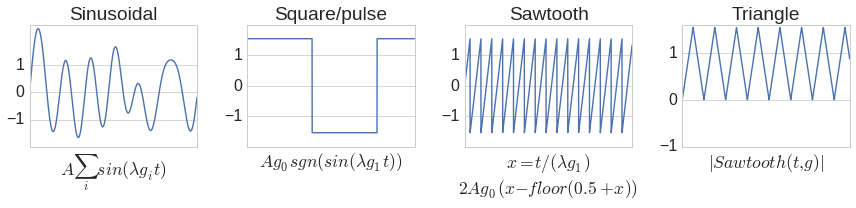

In [8]:
genes = np.random.uniform(size=7)*2 -1
x = np.linspace(0,500,10000)

#figure beautification
seaborn.set_context('paper',font_scale=2)
seaborn.set_style('whitegrid')

fig,axes = plt.subplots(1,4, figsize=(12,3))

axes[0].plot(x,sinusoidalI(x,genes=genes))
axes[0].set_title('Sinusoidal')
axes[0].set_xlabel('$A \sum_i sin(\lambda g_i t)$')

axes[1].plot(x,squareI(x,genes=genes))
axes[1].set_title('Square/pulse')
axes[1].set_xlabel('$A g_0 sgn(sin(\lambda g_1 t))$')

axes[2].plot(x,sawtoothI(x,genes=genes))
axes[2].set_title('Sawtooth')
axes[2].set_xlabel('$x = {t}/(\lambda g_1)$\n$2A g_0 (x-floor(0.5+x))$')

axes[3].plot(x,triangleI(x,genes=genes))
axes[3].set_title('Triangle')
axes[3].set_xlabel('$|Sawtooth(t,g)|$')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([-1.,0,1.])

plt.tight_layout()
# fig.savefig('methods_input_regimes.pdf') #uncomment to save figure to PDF

plt.show()

##2.2.2 Fitness functions
Here is how the plot with the mean network output was constructed:

In [10]:
#load data from CSV file
mean_network_output_evolved = pd.read_csv(os.getcwd() + '/single_networks/evolved01-07-15 175733.csv')
mean_network_output_fixed = pd.read_csv(os.getcwd() + '/single_networks/fixed01-07-15 175733.csv')

#print top five rows to verify we're looking at the right thing
mean_network_output_evolved.head()

,neur0,input0,neur1,input1,neur2,input2,neur3,input3,neur4,input4
0,0.626002,0.588757,0.648553,0,0.532569,0,0.542782,0,0.623563,0
1,0.134031,0.488020,0.124551,0,0.374768,0,0.529845,0,0.489327,0
2,0.084377,0.439653,0.067235,0,0.259195,0,0.528855,0,0.394075,0
3,0.073147,0.285162,0.074213,0,0.176688,0,0.530870,0,0.330896,0
4,0.074435,0.240266,0.106851,0,0.119326,0,0.531736,0,0.288748,0


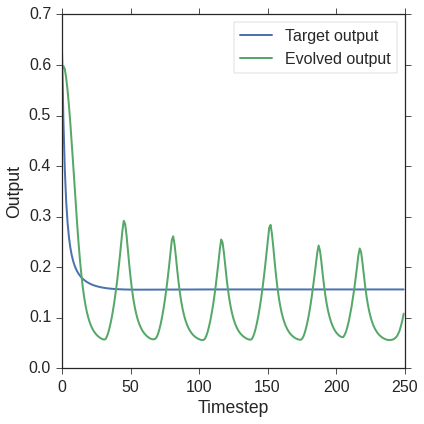

In [11]:
seaborn.set_context("paper", font_scale=2, rc={"lines.linewidth": 2})
seaborn.set_style('ticks')
fig = plt.figure(figsize=(6,6))

plt.plot(mean_network_output_evolved[:250]['neur4'], label='Target output')
plt.plot(mean_network_output_fixed[:250]['neur4'], label= 'Evolved output')

plt.xlabel('Timestep')
plt.ylabel('Output')
legend = plt.legend(loc="upper right")
legend.set_frame_on(True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('grey')

plt.tight_layout()
# fig.savefig('methods_mean_output.pdf')
plt.show()

#3. Results
##3.1 Summary
To produce the summary bar graph and example CTRNN traces, the individual max fitnesses at the end of each run for each network size was collated and saved to a CSV file, as well as selected CSV files of the CTRNN outputs.

In [29]:
data = {}
data[2] = {}
data[2]['tests'] = np.genfromtxt('summary/2node_tests.csv') #load array from CSV
data[2]['notests'] = np.genfromtxt('summary/2node_notests.csv')

data[3] = {} 
data[3]['tests'] = np.hstack( #we're combining two different datasets into one array
    [np.genfromtxt('summary/3node_tests_1.csv'),np.genfromtxt('summary/3node_tests_2.csv')]
)
data[3]['notests'] = np.hstack([np.genfromtxt('summary/3node_notests_1.csv'),np.genfromtxt('summary/3node_notests_2.csv')])

data[5] = {}
data[5]['tests'] = np.genfromtxt('summary/5node_tests.csv')
data[5]['notests'] = np.genfromtxt('summary/5node_notests.csv')

data[10] = {}
data[10]['tests'] = np.genfromtxt('summary/10node_tests.csv')
data[10]['notests'] = np.genfromtxt('summary/10node_notests.csv')

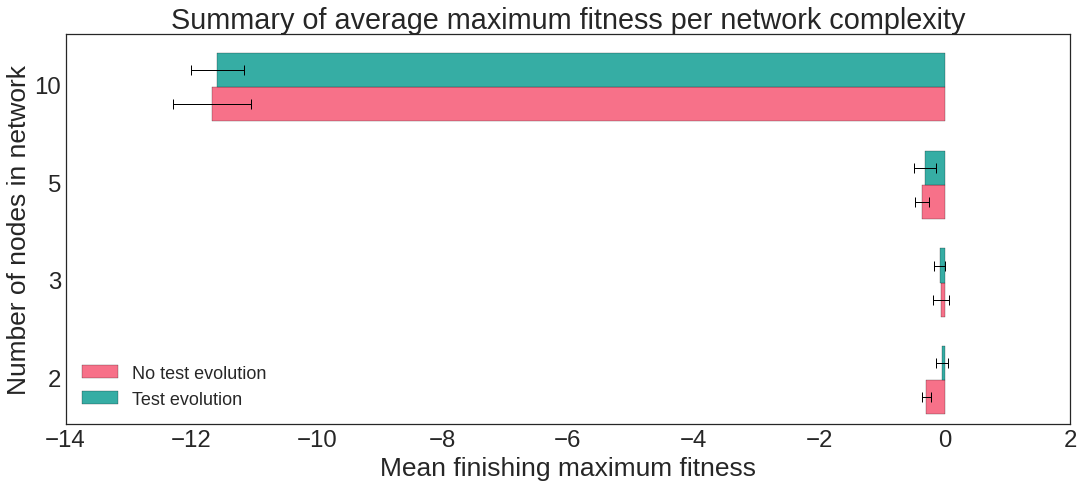

In [30]:
ind = np.arange(4)+0.1
xlabels = [2,3,5,10]

width=0.35

seaborn.set_style('white')
seaborn.set_context("paper", font_scale=3, rc={"lines.linewidth": 2.5})

testMeans = [np.mean(data[2]['tests']),np.mean(data[3]['tests']),np.mean(data[5]['tests']),np.mean(data[10]['tests'])]
testStds = [np.std(data[2]['tests']),np.std(data[3]['tests']),np.std(data[5]['tests']),np.std(data[10]['tests'])]

notestMeans = [np.mean(data[2]['notests']),np.mean(data[3]['notests']),np.mean(data[5]['notests']),np.mean(data[10]['notests'])]
notestStds = [np.std(data[2]['notests']),np.std(data[3]['notests']),np.std(data[5]['notests']),np.std(data[10]['notests'])]

fig,ax = plt.subplots(figsize=(18,7))

colors = seaborn.husl_palette(2)

rects1 = ax.barh(
    ind,
    notestMeans,
    width,
    xerr=notestStds,
    color=colors[0],
    error_kw={
        'ecolor':'black',
        'linewidth':1,
        'capsize':5,
        'capthick':1
    }
)
rects2 = ax.barh(
    ind+width,
    testMeans,
    width,
    xerr=testStds,
    color=colors[1],
    error_kw={
        'ecolor':'black',
        'linewidth':1,
        'capsize':5,
        'capthick':1
    }
)

plt.legend((rects1[0],rects2[0]),('No test evolution','Test evolution'),loc='lower left',prop={'size':18})

ax.set_yticks(ind+width)
ax.set_yticklabels(xlabels)

plt.title('Summary of average maximum fitness per network complexity')

plt.ylabel('Number of nodes in network')
plt.xlabel('Mean finishing maximum fitness')

# plt.savefig('summary.pdf')

plt.show()

In [31]:
def plotSmallNet(ax,evdata,fxdata,titlenum):
    inputax = []

    seaborn.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 4})

    ax.set_title('%d node' % titlenum)
    line1=ax.plot(evdata['neur%d' % (titlenum-1)],label='model')
    line2=ax.plot(fxdata['neur%d' % (titlenum-1)],label='target')
    inputax.append(ax.twinx())
    inputax[-1].plot(fxdata['input0'],color='gray',linestyle='--')
    inputax[-1].set_yticklabels([])

    ax.set_xticks([0.,500.])
    ax.set_yticks([-1.,0.,1.])

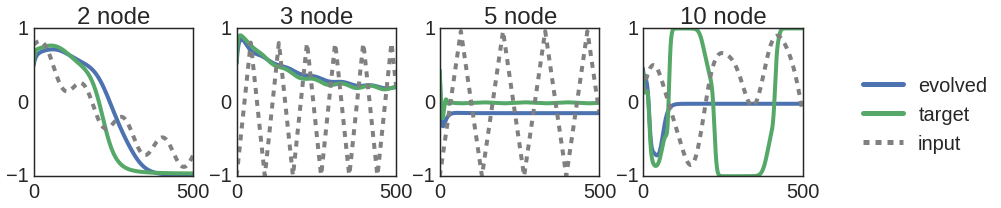

In [33]:
from matplotlib import patches,lines

fig,axes = plt.subplots(1,4,figsize=(14,3))
keys = [2,3,5,10]
for k,ax in zip(keys,axes):
    plotSmallNet(ax,pd.read_csv('summary/%dnodeevolved.csv' % k),pd.read_csv('summary/%dnodefixed.csv' % k),k)


model_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[0],linewidth=5)
target_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[1],linewidth=5)
input_line = lines.Line2D([0],[0],color='gray',linestyle='--',linewidth=5)

plt.figlegend([model_patch,target_patch,input_line],['evolved','target','input'],'center right',ncol=1,bbox_to_anchor = (0,-0.05,1,1),
            bbox_transform = plt.gcf().transFigure)    

plt.tight_layout()
plt.subplots_adjust(right=0.8)
#
# fig.savefig('summary_ctrnn.pdf')

##3.2 Ratio of tests:models

To load and process all the GA data (which is spread across dozens of CSV files), we use the combination of Glob (which returns an array of filenames which match a wildcard, e.g. '*/GA/inputStats*') and regex, which extract parameters from the filenames and check that they match the specified format (so that data from other experiments doesn't get accidentally loaded). 

In [12]:
param_pattern = re.compile(r'\d\d-\d\d-\d\d \d{6}_(\d+_\d{3})')
def getData(subpat):
    d = {}
    for f in glob.glob(subpat):
        k = param_pattern.findall(f)[0].replace('_',':')
        if(k not in d.keys()):
            d[k] = []
        
        data = pd.read_csv(f)
        if(data.shape[0] > 0 and data.shape[1] > 0):
            d[k].append(data)
    return d

Load data, and show which classes of parameters are available:

In [14]:
modelStats = getData('data/2node_ratio/*/GA/modelStats*')
modelStats.keys()

dict_keys(['100:200', '0:200', '10:200', '40:200', '20:200', '50:200', '200:200'])

Producing the GA trace is tricky as we must calculate the means and standard deviation run for each parameter: 

In [15]:
def runStats(data):
    
    def meanDiffSq(x,u):
        diff = u-x
        return diff*diff

    aveModelMeans = {}
    aveModelCI = {}

    for k in data.keys():
        n = len(data[k])
        sumdata = None
        sumdata = data[k][0].copy()
        for d in data[k][1:]:
            sumdata += d.copy()
        aveModelMeans[k] = (sumdata)/n
        stddata = None
        stddata = meanDiffSq(data[k][0].copy(),aveModelMeans[k].copy())

        for d in data[k][1:]:
            stddata += meanDiffSq(d.copy(),aveModelMeans[k].copy())

        aveModelCI[k] = (stddata/n).apply(np.sqrt)
        aveModelCI[k]['Generation'] = data[k][0]['Generation']
        
    return aveModelMeans,aveModelCI

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


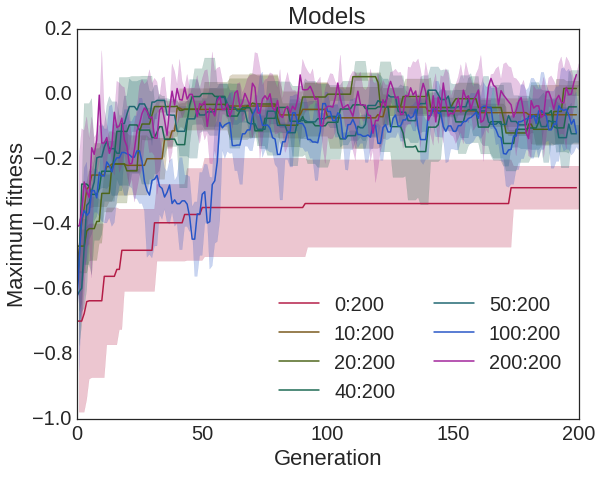

In [16]:
aveModelMeans,aveModelCI = runStats(modelStats)

seaborn.set_style('white')
seaborn.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 1.5})

# alternative colors
# colors = seaborn.cubehelix_palette(7, start=1, rot=-5,dark=.1, light=.5)
colors = seaborn.husl_palette(7,l=.4)

# add a column of 0.25s to the colors to add transparency
shaded = np.hstack([colors,0.25*np.ones((7,1))])

fig,ax = plt.subplots(figsize=(9,7))

#these keys don't sort nicely manually so have to type the literals
sortedKeys = ['0:200','10:200','20:200','40:200','50:200','100:200','200:200']

for i,k in enumerate(sortedKeys):
    u = aveModelMeans[k]['Max fitness'] #mean
    
    # note: original the shading showed 95% CIs (like some of the other plots)
    # but they were too messy for this plot so instead just one standard
    # deviation is shown. Comment out the end of the line to see it with CIs
    
    ci = aveModelCI[k]['Max fitness'] #*1.95
    
    # plot mean line
    ax.plot(u,color=colors[i],label=k)
    
    #shade standard deviation/CIs
    ax.fill_between(aveModelMeans[k]['Generation'],u-ci,u+ci,color=shaded[i])

plt.title('Models')
plt.ylabel('Maximum fitness')
plt.xlabel('Generation')
    
plt.legend(loc='lower right',ncol=2)

# fig.savefig('models_ratio_GA_summary.pdf')

fig.show()

Now to do the same for the tests GA:

In [109]:
inputStats = getData('data/ratio/*/GA/modelStats*')
inputStats.keys()

dict_keys(['0:200', '10:200', '40:200', '20:200', '50:200', '100:200', '200:200'])

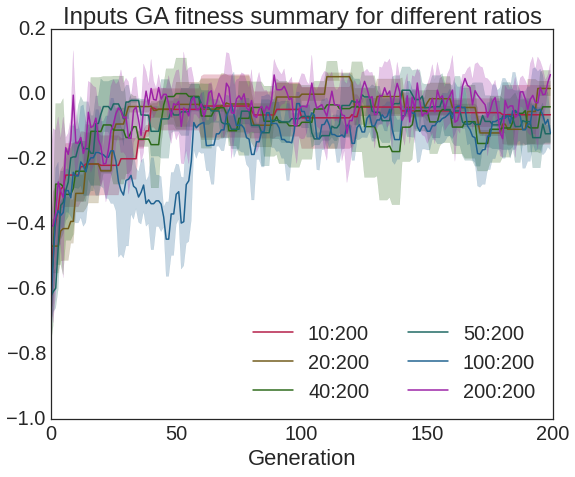

In [110]:
aveInputMeans,aveInputCI = runStats(inputStats)
seaborn.set_style('white')
seaborn.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 1.5})

# colors = seaborn.cubehelix_palette(7, start=1, rot=-5,dark=.1, light=.5)
colors = seaborn.husl_palette(6,l=.4)

shaded = np.hstack([colors,0.25*np.ones((6,1))])

fig,ax = plt.subplots(figsize=(9,7))
inputsortedKeys = ['10:200','20:200','40:200','50:200','100:200','200:200']
for i,k in enumerate(inputsortedKeys):
    u = aveInputMeans[k]['Max fitness']
    ci = aveInputCI[k]['Max fitness']
    ax.plot(u.index/(aveInputMeans[k]['Generation'].irow(-1)/200),u,color=colors[i],label=k)
    ax.fill_between(u.index/(aveInputMeans[k]['Generation'].irow(-1)/200),u-ci,u+ci,color=shaded[i])

plt.title('Inputs GA fitness summary for different ratios')
plt.xlabel('Generation')
    
plt.legend(loc='lower right',ncol=2)

# fig.savefig('inputs_ratio_GA_summary.pdf')

fig.show()

Let's do a t-test to confirm observation that tests is higher than no tests:

In [111]:
notests,tests = [],[]

for d in modelStats['0:200']:        
    notests.append(d['Max fitness'].irow(-1))
for k in sortedKeys[1:]:
    for d in modelStats[k]:        
        tests.append(d['Max fitness'].irow(-1))

print("Tests:\t\tmean=%.2f\tstdev=%.2f\tN=%d" % (np.mean(tests),np.std(tests),len(tests)))
print("No tests:\tmean=%.2f\tstdev=%.2f\tN=%d" % (np.mean(notests), np.std(notests),len(notests)))
        
        
t,p =stats.ttest_ind(notests,tests,equal_var=False)
p /= 2
print("t=%.2f, p=%.3f" % (t,p))

Tests:		mean=-0.05	stdev=0.09	N=18
No tests:	mean=-0.29	stdev=0.07	N=3
t=-4.68, p=0.009


Similarly we can load and plot some CTRNN traces:

In [112]:
ctrnnExp = getData('data/ratio/*/inspector/evolvedLOG_exp*')
fixedExp = getData('data/ratio/*/inspector/fixedLOG_exp*')
ctrnnStd = getData('data/ratio/*/inspector/evolvedLOG_std*')
fixedStd = getData('data/ratio/*/inspector/fixedLOG_std*')

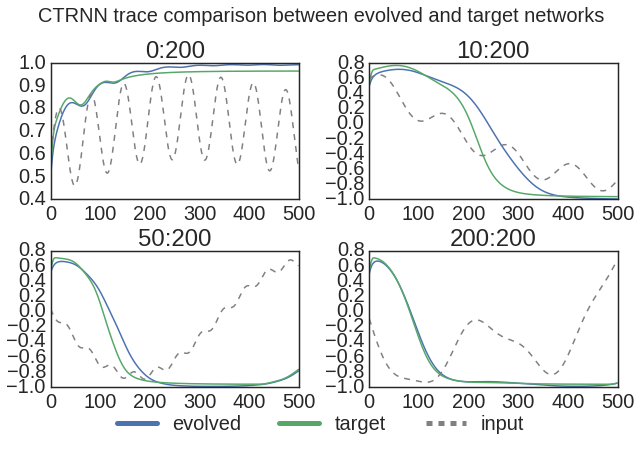

In [113]:
from matplotlib import patches,lines

fig,axes = plt.subplots(2,2,figsize=(9,5))
axes = axes.flatten()
inputax = []

def plotCTRNN(ax,key):
    ax.set_title(key)
    line1=ax.plot(ctrnnExp[key][0]['neur1'],label='model')
    line2=ax.plot(fixedExp[key][0]['neur1'],label='target')
    inputax.append(ax.twinx())
    inputax[-1].plot(fixedExp[key][0]['input0'],color='gray',linestyle='--')
    inputax[-1].set_yticklabels([])

plotCTRNN(axes[0],'0:200')
plotCTRNN(axes[1],'10:200')
plotCTRNN(axes[2],'50:200')
plotCTRNN(axes[3],'200:200')

fig.set_size_inches(9,6)


model_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[0],linewidth=5)
target_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[1],linewidth=5)
input_line = lines.Line2D([0],[0],color='gray',linestyle='--',linewidth=5)

plt.figlegend([model_patch,target_patch,input_line],['evolved','target','input'],'lower center',ncol=3,bbox_to_anchor = (0,-0.05,1,1),
            bbox_transform = plt.gcf().transFigure)

fig.suptitle('CTRNN trace comparison between evolved and target networks',fontsize=20)
fig.tight_layout()
plt.subplots_adjust(top=0.85,bottom=0.1)
plt.show()

And here are the network's responses to a $sin(t/25)$ wave:

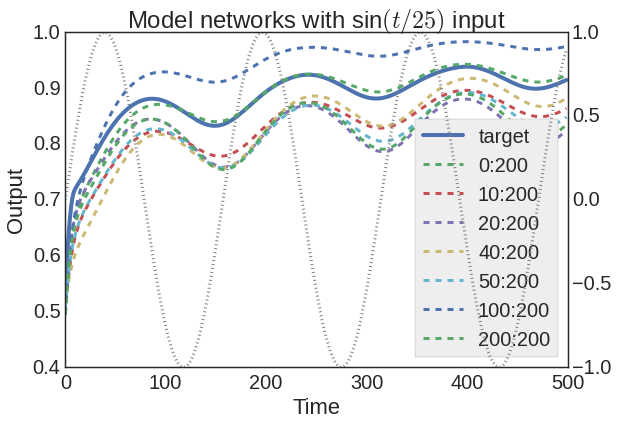

In [114]:
fig,ax = plt.subplots(figsize=(9,6))

lines = []
lines.append(ax.plot(fixedStd['0:200'][0]['neur1'],linewidth=4, label='target')[0])

for key in sortedKeys:
    lines.append(ax.plot(ctrnnStd[key][0]['neur1'],linewidth=3,linestyle='--',label=key)[0])

plt.ylabel('Output')
plt.xlabel('Time')

inputAx = ax.twinx()
line5=inputAx.plot(fixedStd['0:200'][0]['input0'],color='gray',linestyle=':',label='input',linewidth=3)
labs= [line.get_label() for line in lines]

legend = ax.legend(lines,labs,loc="lower right")
legend.set_frame_on(True)
legend.get_frame().set_facecolor('#EEEEEE')
legend.get_frame().set_edgecolor('grey')

plt.title('Model networks with sin$(t/25)$ input')

plt.show()

##3.3: Sinusoidal input
We need a slightly different loading function as the filenames are slightly different.

In [17]:
param_pattern = re.compile(r'\d\d-\d\d-\d\d \d{6}_(\D*)(\d+\.?\d*)\/')
def getData(subpat):
    d = {}
    for f in glob.glob(subpat):
        supkey,key = param_pattern.findall(f)[0]
        key = float(key)
        if(supkey not in d.keys()):
            d[supkey] = {}
        if(key not in d[supkey].keys()):
            d[supkey][key] = []
        
        data = pd.read_csv(f)
        if(data.shape[0] > 0 and data.shape[1] > 0):
            d[supkey][key].append(data)
    return d

In [18]:
modelStats = getData('data/sine/*/GA/modelStats*')
ampst = modelStats['amp']
freqst = modelStats['freq']
ampst.keys()

dict_keys([0.75, 1.25, 2.0, 1.5, 0.5, 1.0])

Now we have a lot of plots to look at, so we use a function to recreate our plot:

In [26]:
def analyseAndPlot(data,title='GA fitness summary',expBoxLoc=(50, -0.9),size=(15,9)):    
    aveModelMeans,aveModelCI = runStats(data)
    sortedKeys = sorted(data.keys())
    n = len(sortedKeys)
    
    seaborn.set_style('white')
    seaborn.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 1.5})
#     colors = seaborn.cubehelix_palette(7, start=1, rot=-5,dark=.1, light=.5)
    colors = seaborn.husl_palette(n,l=.4)

    shaded = np.hstack([colors,0.25*np.ones((n,1))])

    fig,ax = plt.subplots(figsize=size)
    for i,k in enumerate(sortedKeys):
        u = aveModelMeans[k]['Max fitness']
        ci = aveModelCI[k]['Max fitness'] * 1.96 #apply CIs to these

        ax.plot(u,color=colors[i],label=k)
        ax.fill_between(aveModelMeans[k]['Generation']-1,u-ci,u+ci,color=shaded[i])

    plt.title(title)
    plt.ylabel('Maximum fitness')
    plt.xlabel('Generation')

    plt.legend(loc='lower right')

    return fig


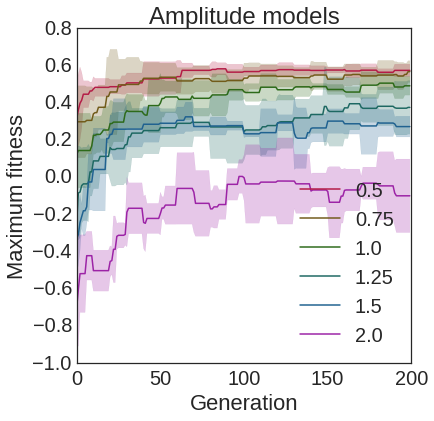

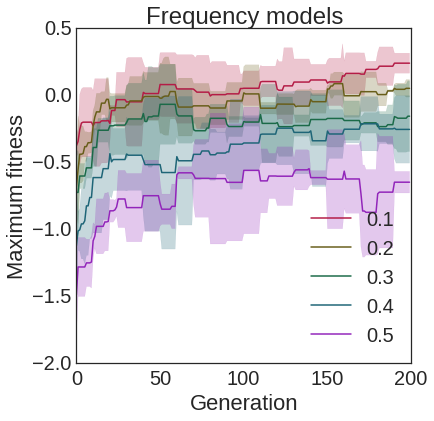

In [27]:
fig = analyseAndPlot(ampst,'Amplitude models',expBoxLoc=(25, -0.9),size=(6,6))
# fig.savefig('model_ga_amplitude_summary.pdf')
fig.show()
fig2 = analyseAndPlot(freqst,'Frequency models',(25, -1.8),size=(6,6))
# fig2.savefig('model_ga_frequency_summary.pdf')
fig2.show()

Let's also do linear regression:

In [21]:
def linR(data):
    collect = []

    sortedKeys = sorted(data.keys())
    for k in sortedKeys:
        for d in data[k]:
            collect.append([k,d['Max fitness'].irow(-1)])

    collect = (np.array(collect).T)
    return stats.linregress(collect[0,:],collect[1,:])

print("AMP \tslope=%.2f\tintercept=%.2f\tR=%.2f\tp=%f\tstderr=%.2f" % linR(ampst))
print("Freq \tslope=%.2f\tintercept=%.2f\tR=%.2f\tp=%f\tstderr=%.2f" % linR(freqst))

AMP 	slope=-0.45	intercept=0.89	R=-0.94	p=0.000000	stderr=0.04
Freq 	slope=-2.08	intercept=0.47	R=-0.94	p=0.000000	stderr=0.21


And more CTRNN traces:

In [22]:
ctrnnExp = getData('data/sine/*/inspector/evolvedLOG_exp*')
fixedExp = getData('data/sine/*/inspector/fixedLOG_exp*')
ctrnnStd = getData('data/sine/*/inspector/evolvedLOG_std*')
fixedStd = getData('data/sine/*/inspector/fixedLOG_std*')

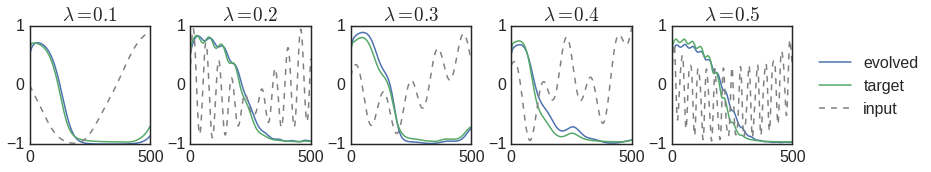

In [23]:
from matplotlib import patches,lines

def plotCTRNNtrace(datakey,layout=(1,5),size=(10,2.5)):
    
    seaborn.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.5})
    
    fig,axes = plt.subplots(layout[0],layout[1],figsize=size)
    axes = axes.flatten()
    inputax = []

    sortedKeys = sorted(ctrnnExp[datakey].keys())

    xticks = [0.,500.]
    yticks = [-1.,0.,1.]
    
    def plotCTRNN(ax,key):
        ax.set_title('$\lambda=%.1f$' % key)
        line1=ax.plot(ctrnnExp[datakey][key][0]['neur1'],label='model')
        line2=ax.plot(fixedExp[datakey][key][0]['neur1'],label='target')
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        
        inputax.append(ax.twinx())
        inputax[-1].plot(fixedExp[datakey][key][0]['input0'],color='gray',linestyle='--')
        inputax[-1].set_yticklabels([])

    for i,key in enumerate(sortedKeys):
        plotCTRNN(axes[i],key)

    fig.set_size_inches(size[0]+3,size[1])


    model_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[0],linewidth=1.5)
    target_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[1],linewidth=1.5)
    input_line = lines.Line2D([0],[0],color='gray',linestyle='--',linewidth=1.5)

    plt.figlegend([model_patch,target_patch,input_line],['evolved','target','input'],'center right',ncol=1,
#                   bbox_to_anchor = (0,0.05,1.15,1),
                bbox_transform = plt.gcf().transFigure)

#     fig.suptitle('CTRNN trace comparison between evolved and target networks',fontsize=20)
    fig.tight_layout()
    plt.subplots_adjust(right=0.85)


#     fig.savefig('inputs_freq_outputs.pdf')
    plt.show()

plotCTRNNtrace('freq')

Looking at the tests population:

In [24]:
inputStats = getData('data/sine/*/GA/inputStats*')
ampInputSt = inputStats['amp']
freqInputSt = inputStats['freq']

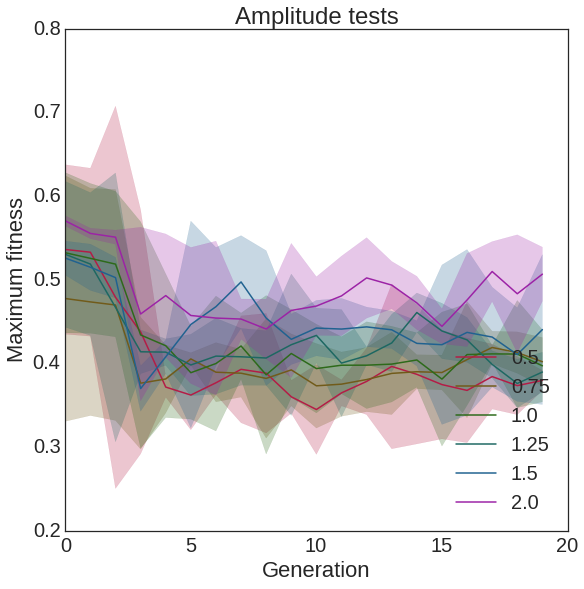

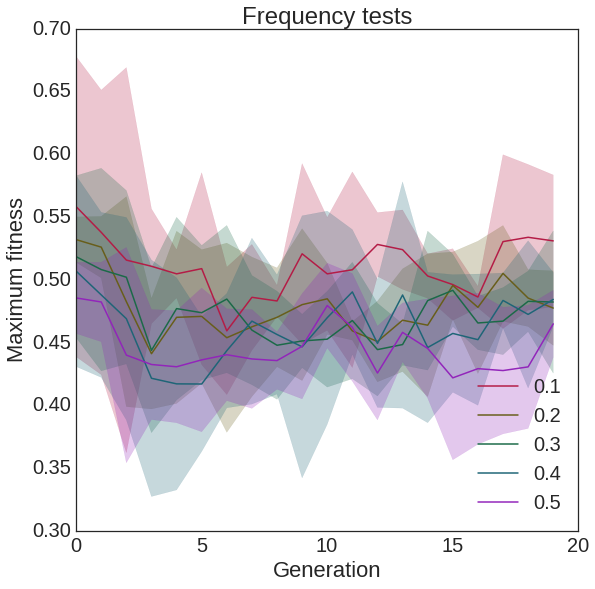

In [28]:
fig = analyseAndPlot(ampInputSt,'Amplitude tests',expBoxLoc=(25, -0.9),size=(9,9))
# fig.savefig('input_ga_amplitude_summary.pdf')
fig.show()
fig2 = analyseAndPlot(freqInputSt,'Frequency tests',(25, -1.8),size=(9,9))
# fig2.savefig('input_ga_frequency_summary.pdf')
fig2.show()

##3.4 Input variation
Again similar process for loading and displaying GA data:

In [34]:
param_pattern = re.compile(r'\d\d-\d\d-\d\d \d{6}_(?P<type>sin|tri|sqr|saw)_(?P<freq>\d+\.?\d*)_(?P<amp>\d+\.?\d*).*')
def getData(subpat):
    d = {}
    for f in glob.glob(subpat):
        result = param_pattern.findall(f)[0]
        (typ,freq,amp) = result
        freq,amp = float(freq),float(amp)
        if(typ not in d.keys()):
            d[typ]= {}
        if(freq not in d[typ].keys()):
            d[typ][freq] = {}
        if(amp not in d[typ][freq].keys()):
            d[typ][freq][amp] = []
        data = pd.read_csv(f)
        if(data.shape[0] > 0 and data.shape[1] > 0):
            d[typ][freq][amp].append(data)
    return d

In [44]:
def calcAveAndStd(data):
    n = len(data)
    
    ave = data[0].copy()
    for d in data[1:]:
        ave += d.copy()
    
    ave = ave / n
    
    std = (ave - data[0].copy())**2
    for d in data[1:]:
        std += (ave - d.copy())**2
    
    std = (std / n).apply(np.sqrt)
    std['Generation'] = ave.copy()['Generation']
    return ave,std

def calcAllStats(data):
    aves,stds = {},{}

    for typ in data.keys():
        aves[typ],stds[typ] = {},{}
        for freq in data[typ]:
            aves[typ][freq],stds[typ][freq] = {},{}
            for amp in data[typ][freq]:
                aves[typ][freq][amp],stds[typ][freq][amp] = calcAveAndStd(data[typ][freq][amp])
    return aves,stds

def gaTrace(data,error,sortedKeys = None,ci_multipler = 1.95,fig=None,ax=None):
    
    if(sortedKeys is None):
        sortedKeys = sorted(data.keys())
    
    n = len(sortedKeys)
    
    seaborn.set_style('white')
    seaborn.set_context("paper", font_scale=3, rc={"lines.linewidth": 1.5})
    # colors = seaborn.cubehelix_palette(7, start=1, rot=-5,dark=.1, light=.5)
    colors = seaborn.husl_palette(n,l=.4)
    shaded = np.hstack([colors,0.25*np.ones((n,1))])
    
    if(fig is None or ax is None):
        fig,ax = plt.subplots(figsize=(7,7))
    
    for i,k in enumerate(sortedKeys):
        u = data[k]['Max fitness']
        ci = error[k]['Max fitness']*ci_multipler

        ax.plot(u,color=colors[i],label=k)
        ax.fill_between(data[k]['Generation']-1,u-ci,u+ci,color=shaded[i])

    plt.subplots_adjust(left=0.15)
        
    return fig,ax

In [45]:
def drawAllGAPlots_amps(aves,stds):
    for typ in aves.keys():
        for freq in aves[typ].keys():
            fig,ax = gaTrace(aves[typ][freq],stds[typ][freq])

            plt.title("%s    %s" % (typ, freq))
            plt.ylabel('Maximum fitness')
            plt.xlabel('Generation')
            plt.legend(loc='lower right')
            fig.show()

In [46]:
def getFreqSummary(aves,stds):
    new_aves,new_stds = {},{}
    for typ in aves.keys():
        new_aves[typ],new_stds[typ] = {},{}
        for freq in aves[typ]:
            keys = list(aves[typ][freq].keys())
            
            new_aves[typ][freq] = aves[typ][freq][keys[0]].copy()
            new_stds[typ][freq] = stds[typ][freq][keys[0]].copy()
            for k in keys[1:]:
                new_aves[typ][freq] += aves[typ][freq][k].copy()
                new_stds[typ][freq] += stds[typ][freq][k].copy()
                
            new_aves[typ][freq] /= len(keys)
            new_stds[typ][freq] /= len(keys)
            
    return new_aves,new_stds

def drawAllGAPlots_freqs(aves,stds):
    for typ in aves.keys():
        fig,ax = gaTrace(aves[typ],stds[typ])

        plt.title(typ)
        plt.ylabel('Maximum fitness')
        plt.xlabel('Generation')
        plt.legend(loc='lower right')
        fig.show()
        
def getTypSummary(aves,stds):
    new_aves,new_stds = {},{}
    for typ in aves.keys():
        keys = list(aves[typ].keys())

        new_aves[typ] = aves[typ][keys[0]].copy()
        new_stds[typ] = stds[typ][keys[0]].copy()
        for k in keys[1:]:
            new_aves[typ] += aves[typ][k].copy()
            new_stds[typ] += stds[typ][k].copy()

        new_aves[typ] /= len(keys)
        new_stds[typ] /= len(keys)
            
    return new_aves,new_stds

def drawGAPlots_typs(aves,stds):
    fig,ax = gaTrace(aves,stds)

    plt.title("GA summary by input type")
    plt.ylabel('Maximum fitness')
    plt.xlabel('Generation')
    plt.legend(loc='lower right')
    return fig

First drawing a lot of plots, separated by frequency:

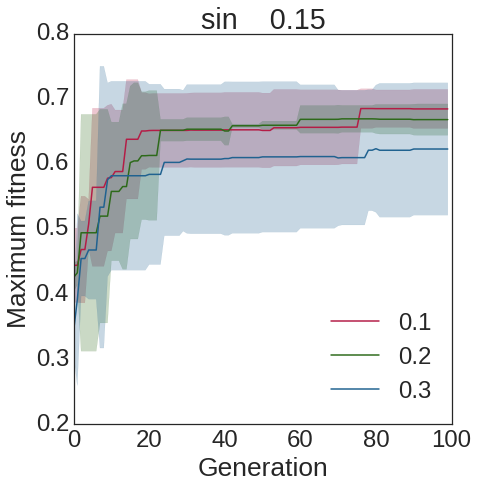

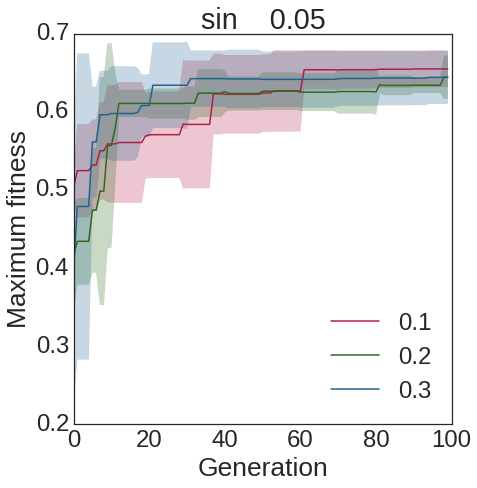

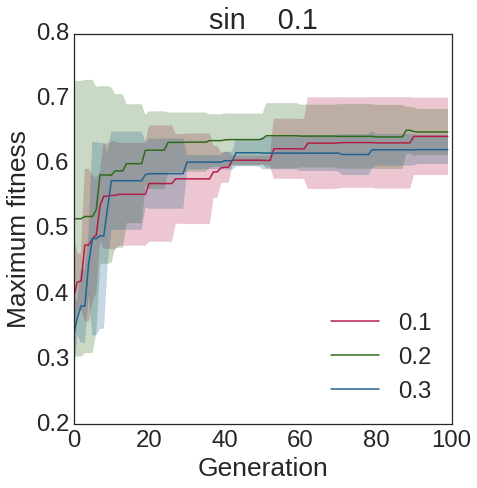

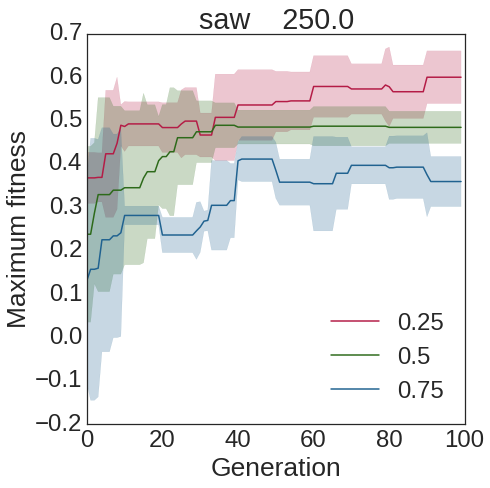

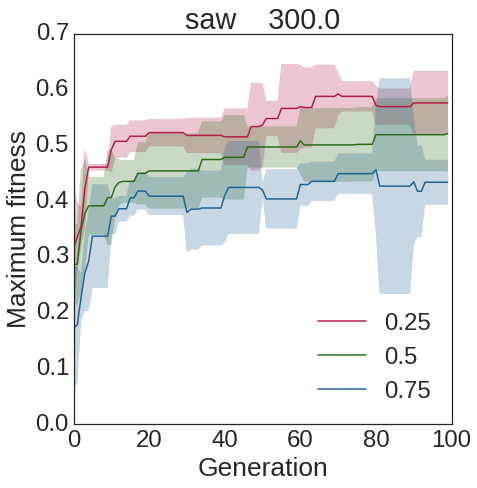

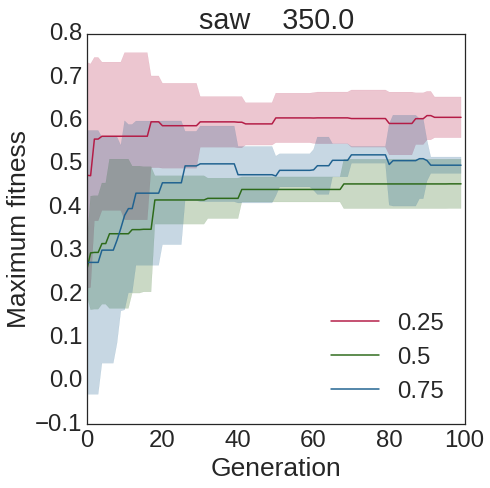

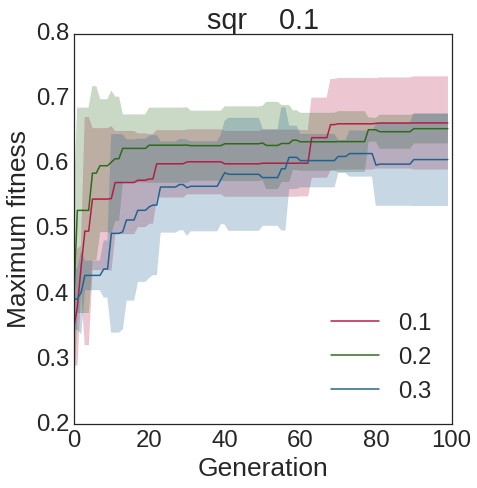

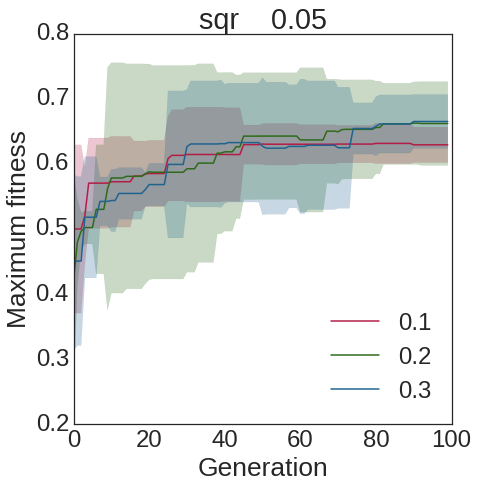

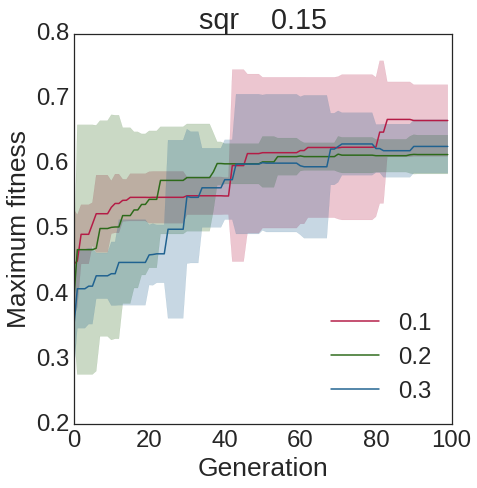

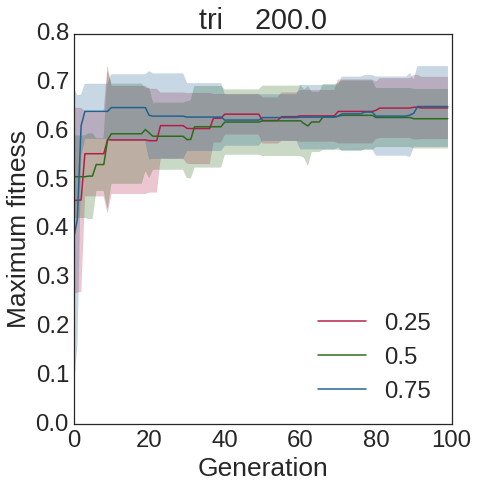

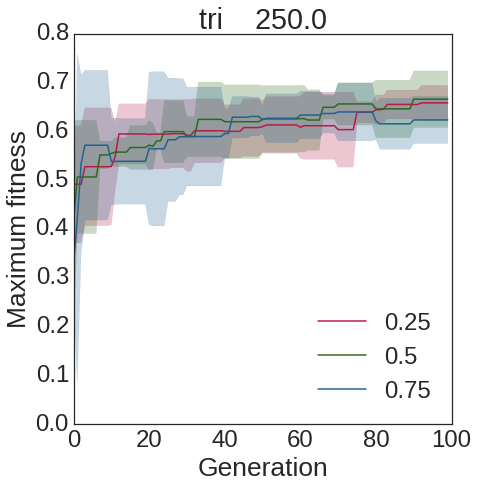

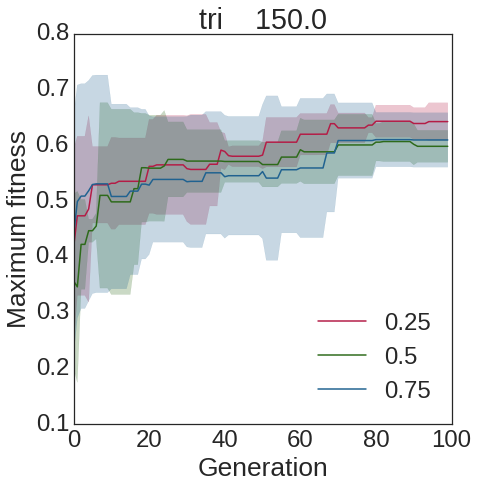

In [59]:
modelStats = getData('data/inputregimes/comparison/*/GA/modelStats*')
model_amp_aves,model_amp_std = calcAllStats(modelStats)
drawAllGAPlots_amps(model_amp_aves,model_amp_std)

Then combine all frequencies used and group by input type:

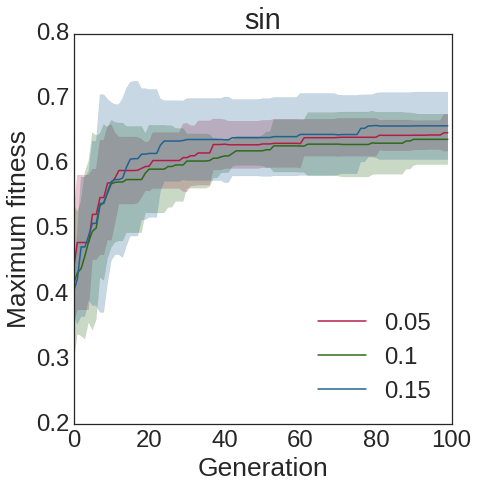

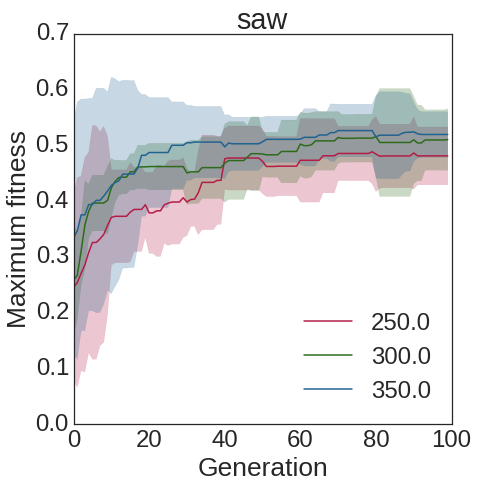

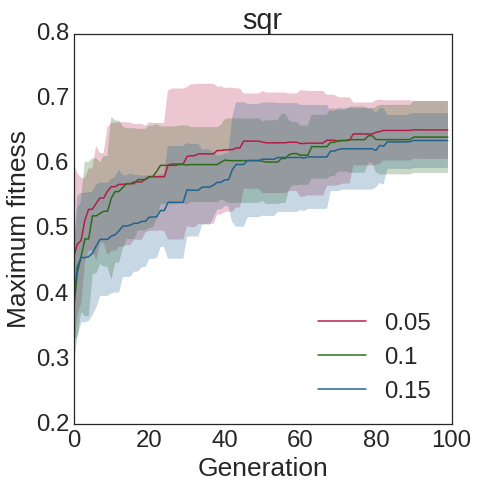

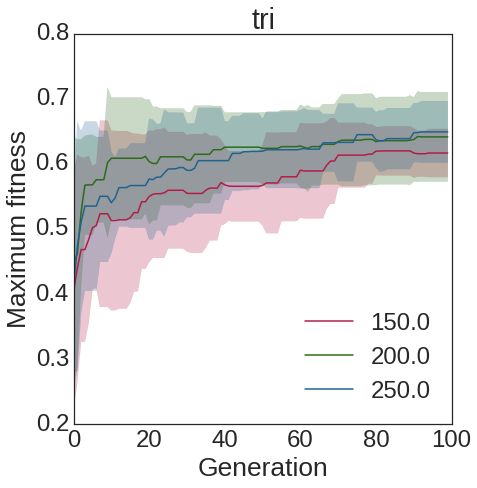

In [60]:
model_freq_aves,model_freq_stds = getFreqSummary(model_amp_aves,model_amp_std)
drawAllGAPlots_freqs(model_freq_aves,model_freq_stds)

And combine all these graphs to produce the summary:

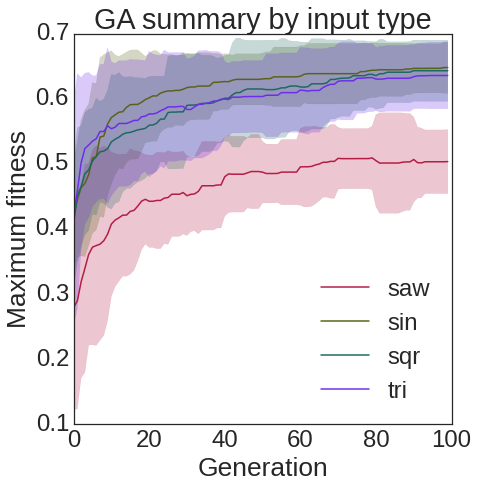

In [61]:
model_summary_aves,model_summary_stds = getTypSummary(model_freq_aves,model_freq_stds)
fig = drawGAPlots_typs(model_summary_aves,model_summary_stds)
# fig.savefig('inputs_summary.pdf')
fig.show()

Let's do a stats test

In [62]:
from scipy import stats

sortedKeys = sorted(modelStats.keys())

saw,others = [],[]

for freq in modelStats['saw']:
    for amp in modelStats['saw'][freq]:
        for d in modelStats['saw'][freq][amp]:
            saw.append(d['Max fitness'].irow(-1))

keys = list(sortedKeys)
keys.remove('saw')    
    
for k in keys:
    for freq in modelStats[k]:   
        for amp in modelStats[k][freq]:
            for d in modelStats[k][freq][amp]:
                others.append(d['Max fitness'].irow(-1))

print("others:\t\tmean=%.2f\tstdev=%.2f\tN=%d" % (np.mean(others),np.std(others),len(others)))
print("saw:\t\tmean=%.2f\tstdev=%.2f\tN=%d" % (np.mean(saw), np.std(saw),len(saw)))
        
        
t,p =stats.ttest_ind(others,saw,equal_var=False)
p /= 2
print("t=%.2f, p=%f" % (t,p))

others:		mean=0.64	stdev=0.03	N=81
saw:		mean=0.50	stdev=0.08	N=29
t=8.92, p=0.000000


###The standardised sine graph (Fig 3.5B)
First load all the ctrnn data; exp is the experiment evolved inputs, std is the response to a standard sine wave

In [63]:
ctrnnExp = getData('data/inputregimes/comparison/*/inspector/evolvedLOG_exp*')
fixedExp = getData('data/inputregimes/comparison/*/inspector/fixedLOG_exp*')
ctrnnStd = getData('data/inputregimes/comparison/*/inspector/evolvedLOG_std*')
fixedStd = getData('data/inputregimes/comparison/*/inspector/fixedLOG_std*')

In [65]:
print(ctrnnExp['tri'].keys())

dict_keys([200.0, 250.0, 150.0])


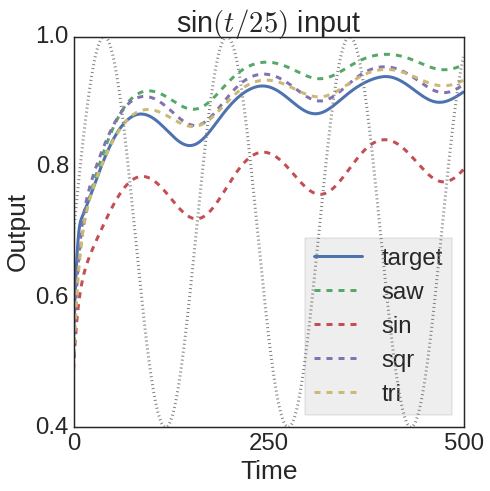

In [67]:
fig,ax = plt.subplots(figsize=(7,7))

sortedKeys = sorted(ctrnnExp.keys())


seaborn.set_context("paper", font_scale=3, rc={"lines.linewidth": 3})

lines = []
lines.append(ax.plot(fixedStd['sin'][0.1][0.1][0]['neur1'],linewidth=3, label='target')[0])


for key in sortedKeys:
    key1 = list(ctrnnStd[key].keys())[1]
    key2 = list(ctrnnStd[key][key1].keys())[1]
    
    
    lines.append(ax.plot(ctrnnStd[key][key1][key2][2]['neur1'],linestyle='--',label=key)[0])
    
plt.ylabel('Output')
plt.xlabel('Time')

inputAx = ax.twinx()
line5=inputAx.plot(fixedStd['sin'][0.1][0.1][0]['input0'],color='gray',linestyle=':',label='input')
labs= [line.get_label() for line in lines]

inputAx.set_yticks([])

legend = ax.legend(lines,labs,loc="lower right")
legend.set_frame_on(True)
legend.get_frame().set_facecolor('#EEEEEE')
legend.get_frame().set_edgecolor('grey')

ax.set_xticks([0.,250.,500.])
ax.set_yticks([.4,.6,.8,1.])

plt.title('sin$(t/25)$ input')


# fig.savefig('inputs_standard_sine.pdf')

plt.show()

##Larger networks
There are several different sets of experiments in the data folder: 3node, 3node_2, 5node and 10node. For brevity only one is shown here as they are generated through the same code

In [82]:
param_pattern = re.compile(r'\d\d-\d\d-\d\d \d{6}_3node_(sin|tri|sqr|saw)_(notests|tests)')
def getData(subpat):
    d = {}
    for f in glob.glob(subpat):
        inptype,tests = param_pattern.findall(f)[0]
        if(inptype not in d.keys()):
            d[inptype]= {}
        if(tests not in d[inptype].keys()):
            d[inptype][tests] = []
        
        data = pd.read_csv(f)
        if(data.shape[0] > 0 and data.shape[1] > 0):
            d[inptype][tests].append(data)
    return d

def calcAveAndStd(data):
    n = len(data)
    
    ave = data[0].copy()
    for d in data[1:]:
        ave += d.copy()
    
    ave = ave / n
    
    std = (ave - data[0].copy())**2
    for d in data[1:]:
        std += (ave - d.copy())**2
    
    std = (std / n).apply(np.sqrt)
    std['Generation'] = ave.copy()['Generation']
    return ave,std

def calcAllStats(data):
    aves,stds = {},{}

    for inptype in data.keys():
        for tests in data[inptype]:
            if(tests not in aves.keys()):
                aves[tests],stds[tests] = {},{}
            if(len(data[inptype][tests]) is not 0):
                aves[tests][inptype],stds[tests][inptype] = calcAveAndStd(data[inptype][tests])
    return aves,stds

In [83]:
def gaTrace(data,error,sortedKeys = None,ci_multipler = 1.95,fig=None,ax=None,typ='',colors=None,linestyle='-'):
    
    if(sortedKeys is None):
        sortedKeys = sorted(data.keys())
    
    n = len(sortedKeys)
    
    seaborn.set_style('white')
    seaborn.set_context("paper", font_scale=3, rc={"lines.linewidth": 2.5})
    
    if(colors is None):
    # colors = seaborn.cubehelix_palette(7, start=1, rot=-5,dark=.1, light=.5)
        colors = seaborn.husl_palette(n,l=.4)
    shaded = np.hstack([colors,0.15*np.ones((n,1))])
    
    if(fig is None or ax is None):
        fig,ax = plt.subplots(figsize=(7,7))
    
    for i,k in enumerate(sortedKeys):
        u = data[k]['Max fitness']
        ci = error[k]['Max fitness']*ci_multipler

        ax.plot(u,color=colors[i],label=k+typ,linestyle=linestyle)
        ax.fill_between(data[k]['Generation']-1,u-ci,u+ci,color=shaded[i])

    plt.subplots_adjust(left=0.2)
        
#     plt.ylim([0.6,1.])
        
    return fig,ax

In [84]:
def drawAllGAPlots(aves,stds):
    for inptype in aves.keys():
        fig,ax = gaTrace(aves[inptype],stds[inptype])

        plt .title("%s" % (inptype))
        plt.ylabel('Maximum fitness')
        plt.xlabel('Generation')
        plt.legend(loc='lower right')
        fig.show()

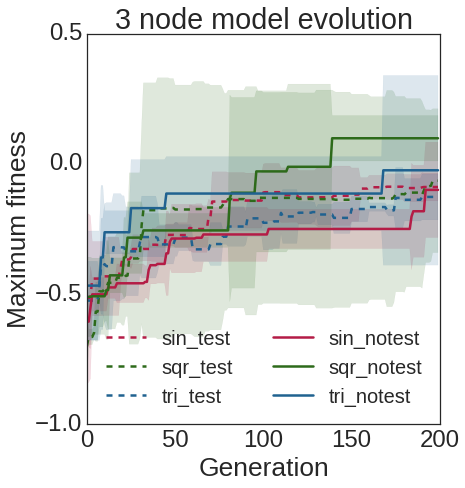

In [85]:
modelStats = getData('data/3node/*/GA/modelStats*')
model_amp_aves,model_amp_std = calcAllStats(modelStats)

# colors = seaborn.husl_palette(6,l=.4)

fig,ax = gaTrace(model_amp_aves['tests'],model_amp_std['tests'],typ='_test',linestyle='--')

gaTrace(model_amp_aves['notests'],model_amp_std['notests'],fig=fig,ax=ax,typ='_notest',linestyle='-')

plt .title('3 node model evolution')
plt.ylabel('Maximum fitness')
plt.xlabel('Generation')
plt.legend(loc='lower right',ncol=2,prop={'size':20})


fig.savefig('3node_ga_summary_1.pdf')

fig.gca().set_yticks([-1.,-.5,0.,.5])

fig.show()


# plt .title('Test evolution')
# plt.ylabel('Maximum fitness')
# plt.xlabel('Generation')
# plt.legend(loc='lower right')
# fig.show()


In [86]:
ctrnnExp = getData('data/3node/*/inspector/evolvedLOG_exp*')
fixedExp = getData('data/3node/*/inspector/fixedLOG_exp*')
ctrnnStd = getData('data/3node/*/inspector/evolvedLOG_std*')
fixedStd = getData('data/3node/*/inspector/fixedLOG_std*')

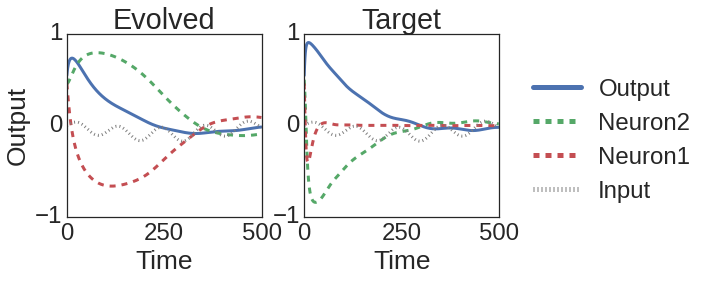

In [87]:
fig,axes = plt.subplots(1,2,figsize=(10,4))


seaborn.set_style('white')
seaborn.set_context("paper", font_scale=3, rc={"lines.linewidth": 3})

index = 2

axes[0].plot(ctrnnExp['sin']['tests'][index]['neur2'])
axes[0].plot(ctrnnExp['sin']['tests'][index]['neur1'],linestyle='--')
axes[0].plot(ctrnnExp['sin']['tests'][index]['neur0'],linestyle='--')
axes[0].plot(ctrnnExp['sin']['tests'][index]['input0'],color='gray',linestyle=':')
axes[0].set_title('Evolved')
axes[0].set_ylabel('Output')
axes[0].set_xlabel('Time')

axes[1].plot(fixedExp['sin']['tests'][index]['neur2'])
axes[1].plot(fixedExp['sin']['tests'][index]['neur1'],linestyle='--')
axes[1].plot(fixedExp['sin']['tests'][index]['neur0'],linestyle='--')
axes[1].plot(fixedExp['sin']['tests'][index]['input0'],color='gray',linestyle=':')
axes[1].set_title('Target')
axes[1].set_xlabel('Time')

for ax in axes:
    ax.set_xticks([0.,250.,500.])
    ax.set_yticks([-1.,0.,1.])

neur1_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[0],linewidth=5)
neur2_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[1],linestyle='--',linewidth=5)
neur3_patch = lines.Line2D([0],[0],color=seaborn.color_palette()[2],linestyle='--',linewidth=5)
input_line = lines.Line2D([0],[0],color='gray',linestyle=':',linewidth=5)

plt.figlegend([neur1_patch,neur2_patch,neur3_patch,input_line],['Output','Neuron2','Neuron1','Input'],'center right',ncol=1,
            bbox_transform = plt.gcf().transFigure)

plt.tight_layout()


plt.subplots_adjust(right=0.7)

# fig.savefig('3node_diffinternals.pdf')

fig.show()